### Bengali handwritten computer vision challange notebook

> Resources i have used
* Pytorch dataset documentation [Here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* Pytorch pre-trained models [Here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
* A lot of google searches 😅

* **Task**
<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1095143%2Fa9a48686e3f385d9456b59bf2035594c%2Fdesc.png?generation=1576531903599785&alt=media" style ="height : 500px">

> The task is multiple classification, given an image you have to predict it's grapheme_root, consonant_diacritic and vowel_diacritic
* **Approach**
> I have used ResNe34 pre-trained model from pytorch, removed the last Linear layer, and added 3 Fully connected layer to classify each category.

> **Outline**
* I have converted all the data into images before hand, i.e reading all the parquet files and building images from each row. 
* Create a Dataset class for the data, For this just follow the pytorch docs and you will good to go.
* Create Model
* Train the Model
* Create Dataset class for testset
* create submission file

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import albumentations
from torchvision import transforms, utils,models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from PIL import Image
import PIL

In [2]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


* Download all the data and put everything in a file called data,

In [3]:
os.listdir('./data')

['.ipynb_checkpoints',
 'class_map.csv',
 'class_map_corrected.csv',
 'sample_submission.csv',
 'test.csv',
 'test_image_data_0.parquet',
 'test_image_data_1.parquet',
 'test_image_data_2.parquet',
 'test_image_data_3.parquet',
 'train.csv',
 'train_image_data_0.parquet',
 'train_image_data_1.parquet',
 'train_image_data_2.parquet',
 'train_image_data_3.parquet',
 'train_multi_diacritics.csv']

* The below method will convert all the parquet files to images

In [4]:
# Data-transform class

def transform_data(files_location,set_ = 'Train'):
    """
    This function will load all the parquet files one by one and convert them to images
    parameters :
    files_location : location where all the files are present i.e .parquet and csv files
    set_ : train or test set,
    """

    files = glob.glob(files_location+f'{set_}_*.parquet')

    for f in files:
        df = pd.read_parquet(f)
        image_ids = df.image_id.values

        df = df.drop('image_id',axis = 1)

        image_array = df.values

        if os.path.isdir(f'./{set_}_images') == False:
            os.mkdir(f'./{set_}_images')

        print(f'Transforming {f} from {set_} :\n')
        for i,img_id in tqdm(enumerate(image_ids),total = len(image_ids),unit=" image"):
            img = image_array[i,:].reshape(137,236).astype(float)
            img_RGB  = Image.fromarray(img).convert("RGB")
            img_RGB.save(f'./{set_}_images/{img_id}.jpg')


In [5]:
files_location = "./data/"
transform_data(files_location)

In [6]:
# let's see how many traning images we have

len(os.listdir('./Train_images/'))

200840

* Create a validation set

In [7]:
# creating a validation set from the Train folder

df_train = pd.read_csv('./data/train.csv')

print('Train shape : ',df_train.shape)

# let's randomly sample 20 percent of data and place it under df_val, then we will move all the files from Train_images
# to Val_images which entries are present in df_val

df_val = df_train.sample((20 * df_train.shape[0])//100)

df_new_train = df_train.drop(df_val.index)

print('New Train shape : ',df_new_train.shape)
print('Validation shape : ',df_val.shape)

if os.path.isdir('./annotations') == False:
    os.mkdir('./annotations')

df_new_train.to_csv('./annotations/Train_annotation.csv',index = False)
df_val.to_csv('./annotations/Val_annotation.csv',index = False)

Train shape :  (200840, 5)
New Train shape :  (160672, 5)
Validation shape :  (40168, 5)


* Tranning Dataset Class

In [8]:
## Don't load the images in the __init__ , load it inside __getitem__ , memory efficient 

class BengaliHandwrittenDataset(Dataset):
    """ Bengali Handwritten dataset """

    def __init__(self,csv_file,root_dir,transform  = "train",image_height = None,image_width = None,mean = None,std = None):
        """
        Args : 
        csv_file : annotation file
        root_dir : image dir
        transform : set on which aug will be applied    
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.image_height = image_height
        self.image_width = image_width
        self.mean = mean
        self.std = std

        if transform == "train":
            self.aug = albumentations.Compose([
                albumentations.CenterCrop(100,200),
                albumentations.Resize(self.image_height,self.image_width,always_apply=True),
                albumentations.ShiftScaleRotate(rotate_limit=2,p = 0.9),
                albumentations.Normalize(mean,std,always_apply=True)
            ])
        
        if transform == "val":
            self.aug = albumentations.Compose([
                albumentations.Resize(self.image_height,self.image_width,always_apply=True),
                albumentations.Normalize(mean,std,always_apply=True)
            ])


    def __len__(self):
        return len(self.labels)

    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image_name = os.path.join(self.root_dir,self.labels.iloc[index,0])
        image = io.imread(image_name+'.jpg')
        image = self.aug(image = image)['image']
        image = np.transpose(image,(2,0,1))
        label = self.labels.iloc[index,1:-1]
        label = np.array([label]).astype(np.long)

        return torch.tensor(image),torch.tensor(label,dtype=torch.long)

In [9]:
train_set = BengaliHandwrittenDataset('./annotations/Train_annotation.csv','./Train_images',transform = 'train',
                                            image_height=224,image_width=224,
                                            mean = (0.485,0.456,0.406),
                                            std = (0.229,0.224,0.225))
val_set = BengaliHandwrittenDataset('./annotations/Val_annotation.csv','./Train_images',transform = 'val',
                                            image_height=224,image_width=224,
                                            mean = (0.485,0.456,0.406),
                                            std = (0.229,0.224,0.225))

In [10]:
print(f'Train_set size = {len(train_set)}')
print(f'Val_set size = {len(val_set)}')

Train_set size = 160672
Val_set size = 40168


In [11]:
def imshow(image,label):
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
    plt.imshow(image)
    plt.title(label)
    plt.show()

* Let's take a sample of batch-size 4 and plot on of the sample

sample batch_sizes : 
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 3])
zeroth sample : 
tensor([[[2.2318, 2.2318, 2.2318,  ..., 2.2147, 2.2147, 2.2147],
         [2.2147, 2.2147, 2.2147,  ..., 2.2147, 2.2147, 2.2147],
         [2.2147, 2.2147, 2.2147,  ..., 2.2147, 2.2147, 2.2147],
         ...,
         [2.2147, 2.2318, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
         [2.2147, 2.2318, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
         [2.2147, 2.2318, 2.2489,  ..., 2.2318, 2.2318, 2.2318]],

        [[2.4111, 2.4111, 2.4111,  ..., 2.3936, 2.3936, 2.3936],
         [2.3936, 2.3936, 2.3936,  ..., 2.3936, 2.3936, 2.3936],
         [2.3936, 2.3936, 2.3936,  ..., 2.3936, 2.3936, 2.3936],
         ...,
         [2.3936, 2.4111, 2.4286,  ..., 2.4111, 2.4111, 2.4111],
         [2.3936, 2.4111, 2.4286,  ..., 2.4111, 2.4111, 2.4111],
         [2.3936, 2.4111, 2.4286,  ..., 2.4111, 2.4111, 2.4111]],

        [[2.6226, 2.6226, 2.6226,  ..., 2.6051, 2.6051, 2.6051],
         [2.6051, 2.6051, 2.6051,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


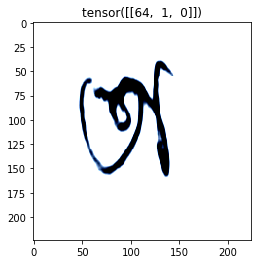

In [12]:
# Let's test the dataset with dataloader
BATCH_SIZE = 4

train_loader = DataLoader(train_set,batch_size = BATCH_SIZE,shuffle=True)

val_loader = DataLoader(val_set,batch_size = BATCH_SIZE,shuffle=True)

iter_ = iter(train_loader)
images,labels = iter_.next()

print('sample batch_sizes : ')
print(images.shape)
print(labels.shape)

print('zeroth sample : ')
print(images[0])
print(labels[0])
print('----------------------------------')
# let's plot zeroth sample
print("zeroth  sample plot -------")
imshow(images[0],labels[0])

* The Model class

In [19]:
# Let's write Model class

class Model_ResNet_34(nn.Module):

    def __init__(self,use_pretrained = False):
        super(Model_ResNet_34,self).__init__()

        if use_pretrained:
            self.base_model_arc  = models.resnet34(pretrained = True)
        else:
            self.base_model_arc = models.resnet34()

        self.base_model_components = list(self.base_model_arc.children())[:-1] # take all the layers except the last one

        self.base_model = nn.Sequential(*self.base_model_components)
        
        # all the CNN layers will calculate good image representation
        
        # now we will add 3 fully connected layer that will classify 3 categories.
        
        self.fc_1 = nn.Linear(512,168)
        self.fc_2 = nn.Linear(512,11)
        self.fc_3 = nn.Linear(512,7)

    def forward(self,x):
        bs ,_,_,_ = x.shape
        x = self.base_model(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(bs,-1)
        fc_1 = self.fc_1(x)
        fc_2 = self.fc_2(x)
        fc_3 = self.fc_3(x)

        return fc_1,fc_2,fc_3    


* Check if the model output is same as we except

In [14]:
# let' see if the model is working or not
m_reset_34 = Model_ResNet_34()
op_1,op_2,op_3 = m_reset_34(images)
print(op_1.shape,op_2.shape,op_3.shape)

torch.Size([4, 168]) torch.Size([4, 11]) torch.Size([4, 7])


* Now we will define
    - Loss fn
    - train fn
    - validation loss calc fn

In [15]:
def loss_fn(outputs,targets):
    op_1,op_2,op_3 = outputs
    t_1, t_2, t_3 = targets[ : ,:,0].argmax(1),targets[ : ,:,1].argmax(1),targets[ : ,:,2].argmax(1)

    l_1 = nn.CrossEntropyLoss()(op_1,t_1)
    l_2 = nn.CrossEntropyLoss()(op_2,t_2)
    l_3 = nn.CrossEntropyLoss()(op_3,t_3)

    return (l_1 + l_2 + l_3) / 3



def train(dataloader, dataset, model, opt):
    model.train()
    model = model.to(device)

    for batch_index,data  in tqdm(enumerate(dataloader), total = len(dataset) // dataloader.batch_size):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs,labels)

        loss.backward()
        opt.step()

        del inputs, labels, outputs # to reduce memory usage in the GPU.
        torch.cuda.empty_cache()


def eval(dataloader, dataset, model,DEVICE):
    model = model.to(DEVICE)
    model.eval()
    final_loss = 0
    counter = 0
    for batch_index,data  in tqdm(enumerate(dataloader), total = len(dataset) // dataloader.batch_size):
        inputs,labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model(inputs)

        loss = loss_fn(outputs,labels)

        counter += 1

        final_loss += loss.item() # if we don't do .item() here, you will run out of GPU memory as all the loss will be 
                                  # accumulated on the gpu, .item() will transfer them to cpu i.e store it on RAM
        del inputs, labels, outputs # to reduce memory usage in the GPU.
        torch.cuda.empty_cache()
    return final_loss / counter   


In [17]:
def learn(BATCH_SIZE,epochs,train_set,val_set):
    train_loader = DataLoader(train_set,batch_size = BATCH_SIZE,shuffle=True)

    val_loader = DataLoader(val_set,batch_size = 4,shuffle=True)

    m_reset_34 = Model_ResNet_34(use_pretrained=True)

    optimizer = torch.optim.Adam(m_reset_34.parameters(),lr = 1e-4)

    for e in range(epochs):
        train(train_loader,train_set,m_reset_34,optimizer)
        
        if os.path.isdir('./Models') == False:
            os.mkdir('./Models')
            
        torch.save(m_reset_34.state_dict(),f'./Models/m_reset_34_epoch_{e}.pth')
        
        val_score = eval(val_loader,val_set,m_reset_34,device)

        print(f'Validation loss : {val_score}')    


In [18]:
learn(156,2,train_set,val_set)

1030it [24:45,  1.47s/it]                                                                                                            
100%|██████████████████████████████████████████████████████████████████████████████████████████| 10042/10042 [04:44<00:00, 35.35it/s]


Validation loss : 0.0007841504124501263


1030it [25:32,  1.44s/it]                                                                                                            
100%|██████████████████████████████████████████████████████████████████████████████████████████| 10042/10042 [04:49<00:00, 34.73it/s]


Validation loss : 0.0002276020365027859


* Unpack test-data
* Write dataset class for test-data
* Write a fn that will create submission file

In [20]:
# let's unpack test sets
files_location = "./data/"
transform_data(files_location,set_ = "Test")

Transforming ./data\test_image_data_0.parquet from Test :



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.01 image/s]


Transforming ./data\test_image_data_1.parquet from Test :



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.13 image/s]


Transforming ./data\test_image_data_2.parquet from Test :



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.04 image/s]


Transforming ./data\test_image_data_3.parquet from Test :



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.96 image/s]


In [21]:
# Dataset_class for Test sets

class BengaliHandwrittenDataset_Test(Dataset):
    """ Bengali Handwritten dataset """

    def __init__(self,csv_file,root_dir,transform  = "val",image_height = None,image_width = None,mean = None,std = None):
        """
        Args : 
        csv_file : annotation file
        root_dir : image dir
        transform : set on which aug will be applied    
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.image_height = image_height
        self.image_width = image_width
        self.mean = mean
        self.std = std
        self.img_id = self.labels.image_id.values
        
        if transform == "val":
            self.aug = albumentations.Compose([
                albumentations.Resize(self.image_height,self.image_width,always_apply=True),
                albumentations.Normalize(mean,std,always_apply=True)
            ])


    def __len__(self):
        return len(self.labels)

    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        image_id = self.img_id[index]
        image_name = os.path.join(self.root_dir,self.labels.iloc[index,1])
        image = io.imread(image_name+'.jpg')
        image = self.aug(image = image)['image']
        image = np.transpose(image,(2,0,1))

        return {
            'image': torch.tensor(image),
            'image_id':image_id
        }

In [22]:
def create_submission_file(model,dataloader,device):
    predictions = []
    model = model.to(device)
    model.eval()
    
    for batch_index,data  in enumerate(dataloader):
        inputs,img_ids = data['image'],data['image_id']
        
        inputs = inputs.to(device)
        op_1,op_2,op_3 = model(inputs)
        
        _,op_1 = torch.max(op_1.data,1)
        _,op_2 = torch.max(op_2.data,1)
        _,op_3 = torch.max(op_3.data,1)
        
    
        for ii,im_id in enumerate(img_ids):
            predictions.append((f"{im_id}_grapheme_root",op_1[ii].item()))
            predictions.append((f"{im_id}_vowel_diacritic",op_2[ii].item()))
            predictions.append((f"{im_id}_consonant_diacritic",op_3[ii].item()))
            
    return predictions
            

In [23]:
testset = BengaliHandwrittenDataset_Test('./data/test.csv','./Test_images/',
                                            image_height=224,image_width=224,
                                            mean = (0.485,0.456,0.406),
                                            std = (0.229,0.224,0.225))

In [24]:
test_loader = DataLoader(testset,batch_size = 64)

In [25]:
model = Model_ResNet_34()
MODEL_NAME = "m_reset_34_epoch_1.pth"
model.load_state_dict(torch.load(f"./Models/{MODEL_NAME}")) # load the trained model

<All keys matched successfully>

In [26]:
list_submission = create_submission_file(model,test_loader,device)

In [27]:
df_sub = pd.DataFrame(data = list_submission,columns = ['row_id','target'])

In [28]:
df_sub.head()

,row_id,target
0,Test_0_grapheme_root,0
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_0_grapheme_root,0
4,Test_0_vowel_diacritic,0


In [29]:
df_sub.to_csv('submission.csv',index = False)